In [76]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql import functions as f
import warnings 
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import getpass

findspark.init()
spark = SparkSession.builder.getOrCreate()

In [3]:
spark

In [78]:
driver = 'com.microsoft.sqlserver.jdbc.SQLServerDriver'
username = 'sa'
password = getpass.getpass('password: ')
db = 'Olist'
server = 'DESKTOP-8RSP3AB'
port = '1433'

df = spark.read \
  .format('jdbc') \
  .option("url", f"jdbc:sqlserver://{server}:{port};databaseName={db};trustServerCertificate=true") \
  .option("dbtable", "[dbo].[olist_orders]") \
  .option('driver', driver) \
  .option("user", username) \
  .option("password", password) \
  .load()

In [5]:
df.show(5)

+--------------------+--------------------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|        02/10/2017 10:56| 02/10/2017 11:07|            04/10/2017 19:55|             10/10/2017 21:25|             18/10/2017 00:00|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|        24/07/2018 20:41| 26/07/2018 03:24|            26/07/2018 14:31|             07/08/2018 15:27|             13/08/2018 00:00|
|47770eb9100c2d0c4...|41ce2a54c0b03bf34...|   delivered

In [6]:
df.toPandas().info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99441 non-null  object
 5   order_delivered_carrier_date   99441 non-null  object
 6   order_delivered_customer_date  99441 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 57.7 MB


In [7]:
df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)



### Entendendo sobre a base

A base possui 99.441 linhas e 8 colunas, sendo elas:

- **order_id**: Identificador único das vendas
- **customer_id:**: Identificador único dos clientes
- **order_status**: Referência ao estado do pedido (entregue, enviado, etc).
- **order_purchase_timestamp**: Mostra o horário da compra.
- **order_approved_at**: Mostra o horário de aprovação do pagamento.
- **order_delivered_carrier_date**: Mostra o horário de postagem do pedido. Quando foi entregue ao parceiro logístico.
- **order_delivered_customer_date**: Mostra a data real de entrega do pedido para o cliente.
- **order_estimated_delivery_date**: Mostra a data estimada de entrega que foi informada ao cliente no momento da compra.

### Analisando as vendas no tempo

In [79]:
df = df.withColumn('order_purchase_timestamp', f.to_timestamp(df['order_purchase_timestamp'], 'dd/MM/yyyy HH:mm'))
df = df.withColumn('order_approved_at', f.to_timestamp(df['order_approved_at'], 'dd/MM/yyyy HH:mm'))
df = df.withColumn('order_delivered_carrier_date', f.to_timestamp(df['order_delivered_carrier_date'], 'dd/MM/yyyy HH:mm'))
df = df.withColumn('order_delivered_customer_date', f.to_timestamp(df['order_delivered_customer_date'], 'dd/MM/yyyy HH:mm'))
df = df.withColumn('order_estimated_delivery_date', f.to_timestamp(df['order_estimated_delivery_date'], 'dd/MM/yyyy HH:mm'))

df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



In [9]:
df.select(f.year('order_approved_at')).distinct().show()

+-----------------------+
|year(order_approved_at)|
+-----------------------+
|                   2018|
|                   2016|
|                   2017|
|                   NULL|
+-----------------------+



In [10]:
df.select('order_status').distinct().show()

+------------+
|order_status|
+------------+
|     shipped|
|    canceled|
|    approved|
|    invoiced|
|     created|
|   delivered|
| unavailable|
|  processing|
+------------+



In [11]:
# Verificando quais status possuem problema com a data (ano nulo)

df.select('order_approved_at', 'order_status').where('YEAR(order_approved_at) IS NULL').select('order_status').distinct().show()

+------------+
|order_status|
+------------+
|    canceled|
|     created|
|   delivered|
+------------+



Como o interesse está em estudar as vendas realizadas e também para corrigir o problema de data vazia na coluna de data de aprovação da venda (provavelmente devido a cancelamentos ou outros problemas durante a venda), podemos **filtrar apenas as vendas que foram aprovadas**.

In [12]:
df_orders = df.select('order_id', 'order_approved_at').where('order_approved_at IS NOT NULL')
df_orders = df_orders.withColumn('date', f.date_format('order_approved_at', 'yyyy-MM'))
df_orders = df_orders.withColumn('year', f.year('order_approved_at'))

df_orders.select('date','year').show(5)

+-------+----+
|   date|year|
+-------+----+
|2017-10|2017|
|2018-07|2018|
|2018-08|2018|
|2017-11|2017|
|2018-02|2018|
+-------+----+
only showing top 5 rows



In [13]:
# Quantidade de vendas por ano

df_orders_year = df_orders\
    .groupBy('year')\
    .agg(
        f.count(df.order_id).alias('qtd_vendas')
    )

df_orders_year.orderBy('qtd_vendas', ascending = False).show()

+----+----------+
|year|qtd_vendas|
+----+----------+
|2018|     53986|
|2017|     44973|
|2016|       322|
+----+----------+



O ano de 2016 apresentou um número de vendas bem abaixo que os anos 2017 e 2018

In [14]:
df_orders_month = df_orders\
    .groupBy('date')\
    .agg(
        f.count(df.order_id).alias('qtd_vendas')
    )\

df_orders_month.orderBy('date', ascending = True).show(10)

+-------+----------+
|   date|qtd_vendas|
+-------+----------+
|2016-09|         1|
|2016-10|       320|
|2016-12|         1|
|2017-01|       760|
|2017-02|      1765|
|2017-03|      2689|
|2017-04|      2374|
|2017-05|      3693|
|2017-06|      3252|
|2017-07|      3974|
+-------+----------+
only showing top 10 rows



In [15]:
df_orders_year = df_orders_year.orderBy('year', ascending = True).toPandas().set_index('year')
df_orders_month = df_orders_month.orderBy('date', ascending = True).toPandas().set_index('date')

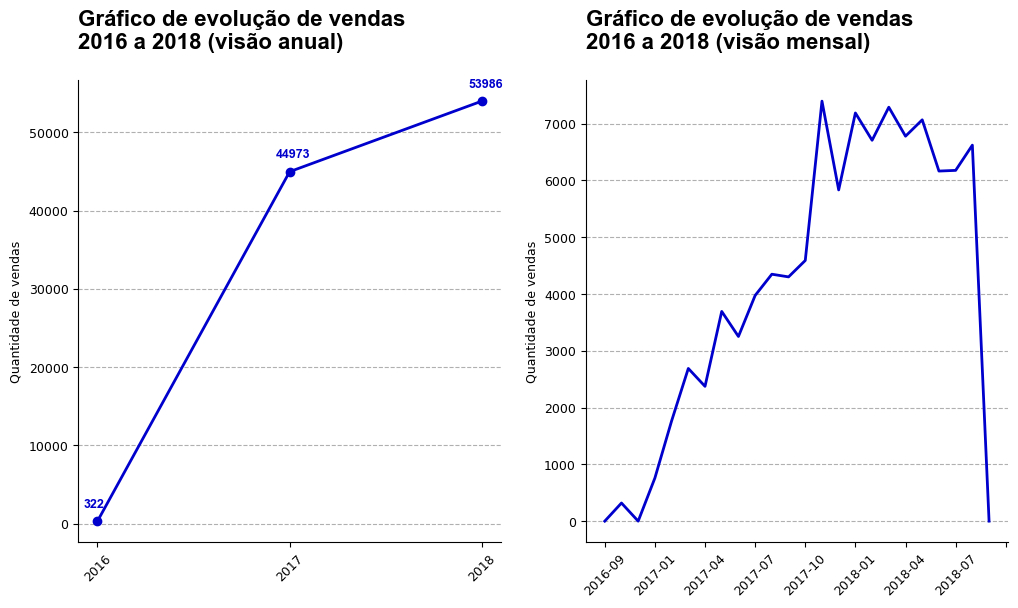

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

# Gráfico 1

ax[0].plot(df_orders_year, lw = 2, marker = 'o', color = 'mediumblue')
ax[0].set_title('Gráfico de evolução de vendas \n2016 a 2018 (visão anual)\n', fontsize = 16, loc = 'left', fontfamily = 'arial', fontweight = 'bold')
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].xaxis.set_tick_params(labelsize = 9, rotation = 45)
ax[0].yaxis.set_tick_params(labelsize = 9)
ax[0].set_ylabel('Quantidade de vendas', fontsize = 9)
ax[0].grid(True, linestyle = '--', axis='y')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

for valor, ano in zip(df_orders_year.qtd_vendas,df_orders_year.index):
    ax[0].text(x = ano-.07,
               y = valor + 2200, 
               s = str(valor), 
               fontsize = 9, 
               ha = 'left', 
               va = 'center', 
               fontfamily = 'arial', 
               fontweight = 'bold', 
               color = 'mediumblue')

# Gráfico 2

ax[1].plot(df_orders_month, lw = 2, color = 'mediumblue')
ax[1].set_title('Gráfico de evolução de vendas \n2016 a 2018 (visão mensal)\n', fontsize = 16, loc = 'left', fontfamily = 'arial', fontweight = 'bold')
ax[1].xaxis.set_major_locator(plt.MultipleLocator(3))
ax[1].xaxis.set_tick_params(labelsize = 9, rotation = 45)
ax[1].yaxis.set_tick_params(labelsize = 9)
ax[1].set_ylabel('Quantidade de vendas', fontsize = 9)
ax[1].grid(True, linestyle = '--', axis='y')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

Através do gráfico de vendas anuais, é possível perceber que o ano de **2016 apresentou uma quantidade bem baixa de vendas em comparação com os demais anos**... 

  - Na base utilizada, o ano de 2016 não possui vendas aprovadas em novembro e apenas 1 pedido em dezembro, o que parece bem incomum para vendas durante esse período devido a BlackFriday e datas comemorativas de fim de ano. O que pode indicar que os dados desse período não sejam fidedignos a realidade, podendo então ser descartados da análise.
  
Além disso, é notável a **tendência de crescimento em vendas entre 2017 e 2018**, com destaque para o **ápice em novembro de 2017** que é esperado devido ao período de BlackFriday. A partir disso, o número de vendas se manteve **relativamente estável, com pouca sazonalidade entre janeiro e maio de 2018**, também é possível perceber **uma queda de vendas em setembro de 2018, que pode indicar alguma incoscistência nos dados** durante esse último período. 

### Análise de vendas em valor

Para analisar os valores referentes as vendas realizadas, usarei uma **tabela referente aos items**, com as seguintes informações:

- **order_id**: Identificador único da venda.
- **order_item_id**: Quantidade de itens (mesmo item) vendidos no pedido.
- **product_id**: Identificador único do produto vendido.
- **seller_id**: Identificador único do vendedor responsável pela venda.
- **shipping_limit_date**: Mostra a data limite de envio do vendedor para repassar o pedido ao parceiro logístico.
- **price**: Valor da venda (para obter o valor total do pedido, fazer order_item_id $*$ price = total_price).
- **freight_value**: Valor do frete.

In [17]:
df_items = spark.read \
  .format('jdbc') \
  .option("url", f"jdbc:sqlserver://{server}:{port};databaseName={db};trustServerCertificate=true") \
  .option("dbtable", "[dbo].[olist_order_items]") \
  .option('driver', driver) \
  .option("user", username) \
  .option("password", password) \
  .load()

df_items.show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date| price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|   19/09/2017 09:45| 58.90|        13.29|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|   03/05/2017 11:05|239.90|        19.93|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|   18/01/2018 14:48|199.00|        17.87|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|   15/08/2018 10:10| 12.99|        12.79|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|df560393f3a51e745...|   13/02/2017 13:57|199.90|        18.14|
+--------------------+-------------+----

In [33]:
df_items.createOrReplaceTempView('itemsView')
df.createOrReplaceTempView('ordersView')

In [34]:
query = '''
WITH CTE AS (
    SELECT 
        orders.order_id,
        DATE_FORMAT(orders.order_approved_at, 'yyyy-MM') AS order_approved_at,
        CAST(items.order_item_id AS INT) AS order_items,
        CAST(items.price AS FLOAT) AS price
    FROM ordersView orders
    INNER JOIN itemsView items
        ON orders.order_id = items.order_id
    WHERE orders.order_approved_at IS NOT NULL
)
SELECT 
    order_approved_at AS date,
    SUM(order_items * price) AS order_value
FROM CTE
WHERE order_approved_at BETWEEN '2015-12' AND '2019-01'
GROUP BY 
    order_approved_at
ORDER BY order_approved_at DESC
'''

df_orders_values_month = spark.sql(query).toPandas().set_index('date').round(2)
df_orders_values_month.head()

,order_value
date,
2018-09,145.00
2018-08,975320.25
2018-07,992118.03
2018-06,981283.47
2018-05,1162168.59


In [35]:
query = '''
WITH CTE AS (
    SELECT 
        orders.order_id,
        YEAR(CAST(orders.order_approved_at AS DATE)) AS year,
        CAST(items.order_item_id AS INT) AS order_items,
        CAST(items.price AS FLOAT) AS price
    FROM ordersView orders
    INNER JOIN itemsView items
        ON orders.order_id = items.order_id
    WHERE orders.order_approved_at IS NOT NULL
)
SELECT 
    year,
    SUM(order_items * price) AS order_value
FROM CTE
WHERE year BETWEEN '2015' AND '2019'
GROUP BY 
    year
ORDER BY year DESC
'''

df_orders_values_year = spark.sql(query).toPandas().set_index('year').round(2)
df_orders_values_year.head()

,order_value
year,
2018,8367626.83
2017,6971842.43
2016,56549.92


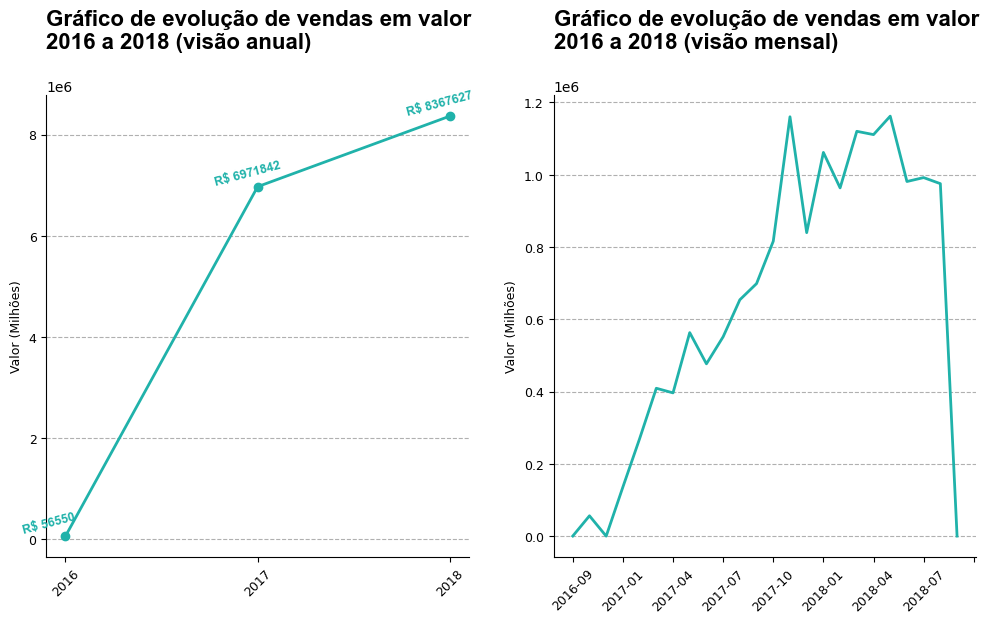

In [36]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

# Gráfico 1

ax[0].plot(df_orders_values_year, lw = 2, marker = 'o', color = 'lightseagreen')
ax[0].set_title('Gráfico de evolução de vendas em valor \n2016 a 2018 (visão anual)\n', fontsize = 16, loc = 'left', fontfamily = 'arial', fontweight = 'bold')
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].xaxis.set_tick_params(labelsize = 9, rotation = 45)
ax[0].yaxis.set_tick_params(labelsize = 9)
ax[0].set_ylabel('Valor (Milhões)', fontsize = 9)
ax[0].grid(True, linestyle = '--', axis='y')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

for valor, ano in zip(df_orders_values_year.order_value,df_orders_values_year.index):
    ax[0].text(x = ano-.23,
               y = valor + 250000, 
               s = f'R$ {str(round(valor))}', 
               fontsize = 9, 
               ha = 'left', 
               va = 'center', 
               fontfamily = 'arial', 
               fontweight = 'bold', 
               color = 'lightseagreen',
               rotation = 15)

# Gráfico 2

ax[1].plot(df_orders_values_month.sort_index(), lw = 2, color = 'lightseagreen')
ax[1].set_title('Gráfico de evolução de vendas em valor \n2016 a 2018 (visão mensal)\n', fontsize = 16, loc = 'left', fontfamily = 'arial', fontweight = 'bold')
ax[1].xaxis.set_major_locator(plt.MultipleLocator(3))
ax[1].xaxis.set_tick_params(labelsize = 9, rotation = 45)
ax[1].yaxis.set_tick_params(labelsize = 9)
ax[1].set_ylabel('Valor (Milhões)', fontsize = 9)
ax[1].grid(True, linestyle = '--', axis='y')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

### Combinando visualizações

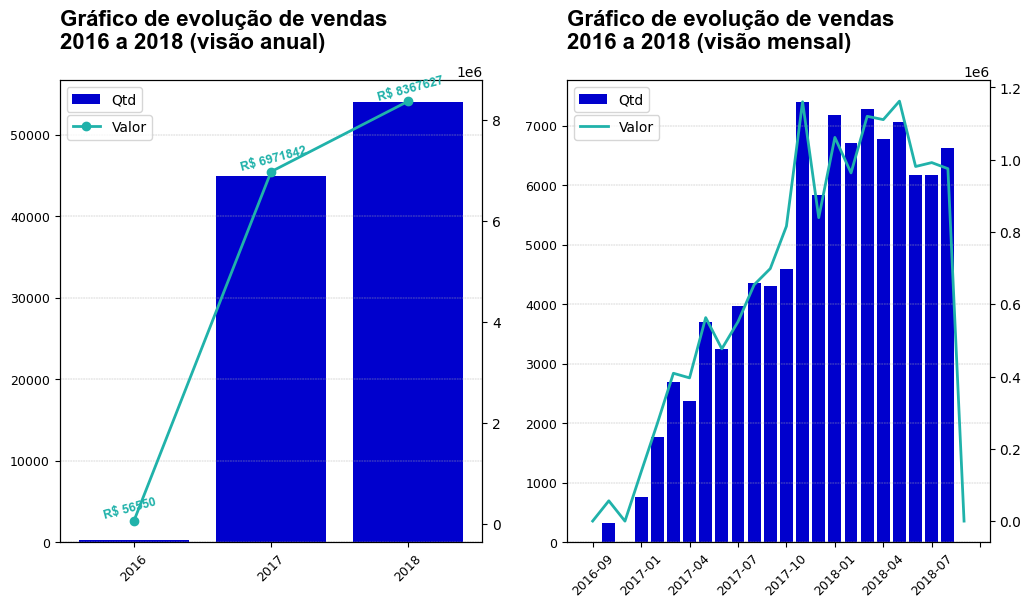

In [37]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax2 = [ax[0].twinx(), ax[1].twinx()]

# gráfico 1

ax[0].bar(df_orders_year.index,df_orders_year.qtd_vendas, color = 'mediumblue', label = 'Qtd')
ax[0].set_title('Gráfico de evolução de vendas \n2016 a 2018 (visão anual)\n', loc = 'left', fontfamily = 'arial', fontweight = 'bold', fontsize=16)
ax[0].xaxis.set_tick_params(labelsize = 9, rotation = 45)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].yaxis.set_tick_params(labelsize = 9)
ax[0].grid(True, axis = 'y', linestyle = '--', linewidth = .35)
ax[0].legend(loc='best')

ax2[0].plot(df_orders_values_year, lw = 2, marker = 'o', color = 'lightseagreen', label = 'Valor')
ax2[0].legend(bbox_to_anchor =(.235,.94))

# gráfico 2
ax[1].bar(df_orders_month.index,df_orders_month.qtd_vendas, color = 'mediumblue', label = 'Qtd')
ax[1].set_title('Gráfico de evolução de vendas \n2016 a 2018 (visão mensal)\n', loc = 'left', fontfamily = 'arial', fontweight = 'bold', fontsize=16)
ax[1].xaxis.set_tick_params(labelsize = 9, rotation = 45)
ax[1].xaxis.set_major_locator(plt.MultipleLocator(3))
ax[1].yaxis.set_tick_params(labelsize = 9)
ax[1].grid(True, axis = 'y', linestyle = '--', linewidth = .35)
ax[1].legend(loc='upper left')

ax2[1].plot(df_orders_values_month, lw = 2, color = 'lightseagreen', label = 'Valor')
ax2[1].legend(bbox_to_anchor = (.235,.94))


for valor, ano in zip(df_orders_values_year.order_value,df_orders_values_year.index):
    ax2[0].text(x = ano-.23,
               y = valor + 250000, 
               s = f'R$ {str(round(valor))}', 
               fontsize = 9, 
               ha = 'left', 
               va = 'center', 
               fontfamily = 'arial', 
               fontweight = 'bold', 
               color = 'lightseagreen',
               rotation = 15)

Os valores parecem acompanhar o gráfico de quantidade de vendas, uma correlação esperada.

### Status dos pedidos

Verificando os pedidos que deixaram de ser faturados, ou seja, pedidos que possuem status do pedido como "cancelado" e possuem venda confirmada.

In [38]:
query = '''
WITH CTE AS (
    SELECT 
        orders.order_id,
        DATE_FORMAT(CAST(orders.order_approved_at AS DATE), 'yyyy-MM') AS order_approved_at,
        CAST(items.order_item_id AS INT) AS order_item_id,
        CAST(items.price AS FLOAT) AS price
    FROM ordersView orders
    INNER JOIN itemsView items 
        ON orders.order_id = items.order_id
    WHERE 
        orders.order_approved_at IS NOT NULL
        AND orders.order_status = 'canceled'
)
SELECT
    order_approved_at AS date,
    SUM(order_item_id * price) AS order_value
FROM CTE
WHERE 
    order_approved_at BETWEEN '2015-12' AND '2019-01'
GROUP BY
    order_approved_at 
ORDER BY 
    order_approved_at DESC
'''

df_orders_canceled_month = spark.sql(query).toPandas().set_index('date').round(2)
df_orders_canceled_month.head()

,order_value
date,
2018-08,6027.33
2018-07,23473.50
2018-06,2065.67
2018-05,5869.76
2018-04,3576.49


In [41]:
query = '''
WITH CTE AS (
    SELECT 
        orders.order_id,
        YEAR(CAST(orders.order_approved_at AS DATE)) AS year,
        CAST(items.order_item_id AS INT) AS order_item_id,
        CAST(items.price AS FLOAT) AS price
    FROM ordersView orders
    INNER JOIN itemsView items 
        ON orders.order_id = items.order_id
    WHERE 
        orders.order_approved_at IS NOT NULL
        AND orders.order_status = 'canceled'
)
SELECT
    year,
    SUM(order_item_id * price) AS order_value
FROM CTE
WHERE 
    year BETWEEN 2015 AND 2019
GROUP BY
    year 
ORDER BY 
    year DESC
'''

df_orders_canceled_year = spark.sql(query).toPandas().set_index('year').round(2)
df_orders_canceled_year.head()

,order_value
year,
2018,54697.30
2017,56697.81
2016,3297.07


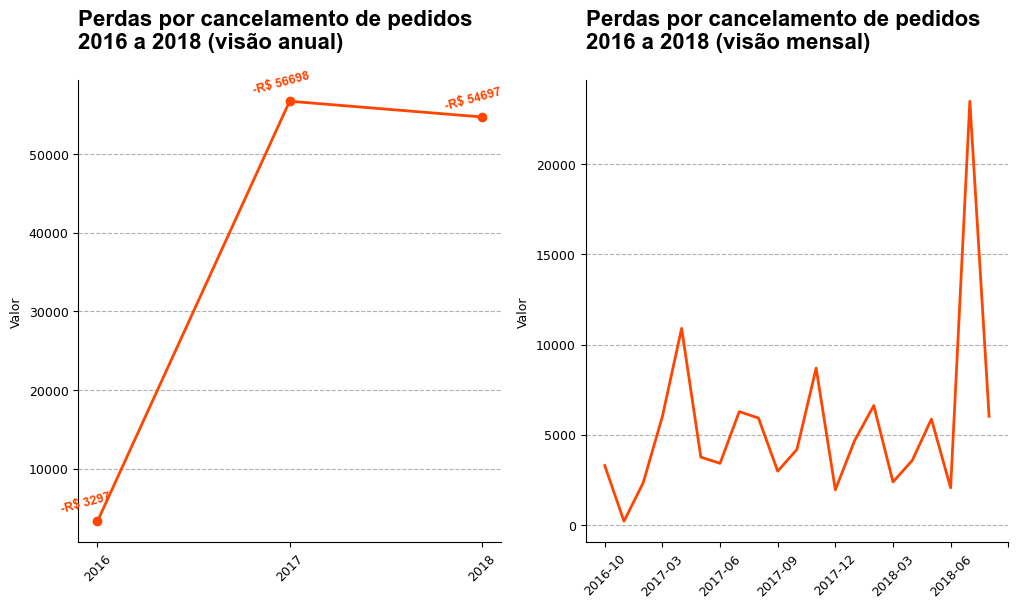

In [46]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

# Gráfico 1
ax[0].plot(df_orders_canceled_year, lw = 2, marker = 'o', color = 'orangered')
ax[0].set_title('Perdas por cancelamento de pedidos \n2016 a 2018 (visão anual)\n', fontsize = 16, loc = 'left', fontfamily = 'arial', fontweight = 'bold')
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].xaxis.set_tick_params(labelsize = 9, rotation = 45)
ax[0].yaxis.set_tick_params(labelsize = 9)
ax[0].set_ylabel('Valor', fontsize = 9)
ax[0].grid(True, linestyle = '--', axis='y')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

for valor, ano in zip(df_orders_canceled_year.order_value,df_orders_canceled_year.index):
    ax[0].text(x = ano-.2,
               y = valor + 2300, 
               s = f'-R$ {str(round(valor))}', 
               fontsize = 9, 
               ha = 'left', 
               va = 'center', 
               fontfamily = 'arial', 
               fontweight = 'bold', 
               color = 'orangered',
               rotation = 15)

# Gráfico 2
ax[1].plot(df_orders_canceled_month.sort_index(), lw = 2, color = 'orangered')
ax[1].set_title('Perdas por cancelamento de pedidos \n2016 a 2018 (visão mensal)\n', fontsize = 16, loc = 'left', fontfamily = 'arial', fontweight = 'bold')
ax[1].xaxis.set_major_locator(plt.MultipleLocator(3))
ax[1].xaxis.set_tick_params(labelsize = 9, rotation = 45)
ax[1].yaxis.set_tick_params(labelsize = 9)
ax[1].set_ylabel('Valor', fontsize = 9)
ax[1].grid(True, linestyle = '--', axis='y')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

Essa visualização mostra que **2018 possui menor perda por cancelamento em comparação com 2017**, porém, devido a um alto valor de cancelamento entre 2018-06 e 2018-08, **2018 pode fechar o ano com maior valor de perda por cancelamento**.  
Além disso, é possível perceber que até antes do pico do gráfico mensal (por volta de 2018-07), a perda era estacionária, ou seja, **a perda por cancelamento tendia a variar em torno da média** que aparentemente é **pouco mais de R$ 5000 / mês**.

### Status do pedido

Definindo o cancelamento das vendas como: 

$$
\begin{cases}
\text{status da venda = 'canceled'} \implies 1 \\
\text{caso contrário} = 0
\end{cases}
$$

In [48]:
df_cust = spark.read \
  .format('jdbc') \
  .option("url", f"jdbc:sqlserver://{server}:{port};databaseName={db};trustServerCertificate=true") \
  .option("dbtable", "[dbo].[olist_customers]") \
  .option('driver', driver) \
  .option("user", username) \
  .option("password", password) \
  .load()

df_cust.createOrReplaceTempView('customersView')
df_cust.show(5)

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
|4e7b3e00288586ebd...|060e732b5b29e8181...|                    1151|           sao paulo|            SP|
|b2b6027bc5c5109e5...|259dac757896d24d7...|                    8775|     mogi das cruzes|            SP|
|4f2d8ab171c80ec83...|345ecd01c38d18a90...|                   13056|            campinas|            SP|
+--------------------+--------------------+------------------------+--------------------+--------------+
only showing top 5 rows



In [50]:
query = '''
WITH CTE AS (
    SELECT 
        orders.order_id,
        DATE_FORMAT(CAST(orders.order_approved_at AS DATE), 'yyyy-MM') AS order_approved_at,
        orders.order_purchase_timestamp,
        CAST(items.order_item_id AS INT) AS order_item_id,
        CAST(items.price AS FLOAT) AS price,
        CAST(items.freight_value AS FLOAT) AS freight_value,
        customers.customer_state AS state,
        customers.customer_city AS city,
        CASE 
            WHEN customers.customer_state IN ('AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO') THEN 'Norte'
            WHEN customers.customer_state IN ('AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE') THEN 'Nordeste'
            WHEN customers.customer_state IN ('DF', 'GO', 'MT', 'MS') THEN 'Centro-Oeste'
            WHEN customers.customer_state IN ('ES', 'MG', 'RJ', 'SP') THEN 'Sudeste'
            WHEN customers.customer_state IN ('PR', 'RS', 'SC') THEN 'Sul'
        END AS region,
        orders.order_status AS status,
        CASE WHEN orders.order_status = 'canceled' THEN 1 ELSE 0 END AS canceled
    FROM ordersView orders
    INNER JOIN itemsView items 
        ON orders.order_id = items.order_id
    INNER JOIN customersView customers
        ON orders.customer_id = customers.customer_id
)
SELECT
    order_id,
    order_approved_at,
    order_purchase_timestamp,
    order_item_id * price AS order_value,
    order_item_id * freight_value AS freight_value,
    city,
    state,
    region,
    status,
    canceled
FROM CTE
WHERE 
    order_approved_at BETWEEN '2015-12' AND '2019-01'
ORDER BY 
    order_approved_at DESC

'''

df_status = spark.sql(query)
df_status.show(5)

+--------------------+-----------------+------------------------+-----------+-------------+--------------+-----+------------+---------+--------+
|            order_id|order_approved_at|order_purchase_timestamp|order_value|freight_value|          city|state|      region|   status|canceled|
+--------------------+-----------------+------------------------+-----------+-------------+--------------+-----+------------+---------+--------+
|54282e97f61c23b78...|          2018-09|     2018-09-03 09:06:00|      145.0|        21.46|     sao paulo|   SP|     Sudeste|  shipped|       0|
|00ab3a43bda739029...|          2018-08|     2018-08-10 12:09:00|       27.9|         7.46|     sao paulo|   SP|     Sudeste|delivered|       0|
|0181409c6498f79e1...|          2018-08|     2018-08-01 15:05:00|       43.9|        18.41|rio de janeiro|   RJ|     Sudeste|delivered|       0|
|003a7f59d7e08a9c6...|          2018-08|     2018-08-19 12:51:00|      119.0|        15.28|      brasilia|   DF|Centro-Oeste|deliv

In [56]:
df_status.select('status').toPandas().value_counts(normalize = True).round(4)

status     
delivered      0.9782
shipped        0.0105
canceled       0.0048
invoiced       0.0032
processing     0.0032
unavailable    0.0001
approved       0.0000
Name: proportion, dtype: float64

Como esperado, **a maioria dos pedidos confirmados foram entregues**, representando **97.8%** dos pedidos analisados.

#### Vendas por região

In [ ]:
df_region_month = df_status.query("order_approved_at > '2016-12'").groupby(['order_approved_at', 'region']).agg(
    qtd_pedidos = ('order_id', 'count'),
    valor_total = ('order_value', 'sum'),
    tkm  = ('order_value', 'mean'),
    valor_medio_frete = ('freight_value', 'mean'),
    qtd_cancelados = ('canceled', 'sum')
).reset_index().set_index('order_approved_at')

df_region_month.head()

In [63]:
df_region_month = df_status.filter(df_status["order_approved_at"] > '2016-12').groupBy('order_approved_at', 'region').agg(
    f.count('order_id').alias('qtd_pedidos'),
    f.sum('order_value').alias('valor_total'),
    f.avg('order_value').alias('tkm'),
    f.avg('freight_value').alias('valor_medio_frete'),
    f.sum('canceled').alias('qtd_cancelados')
).orderBy('order_approved_at', ascending = True).toPandas().set_index('order_approved_at')

df_region_month.head()

,region,qtd_pedidos,valor_total,tkm,valor_medio_frete,qtd_cancelados
order_approved_at,,,,,,
2017-01,Centro-Oeste,65,14322.100033,220.340001,20.514462,0
2017-01,Sudeste,584,81904.589741,140.247585,20.136901,1
2017-01,Nordeste,74,10905.700054,147.374325,24.595541,0
2017-01,Sul,164,24008.509918,146.393353,19.343659,1
2017-01,Norte,21,4776.749962,227.464284,49.565238,0


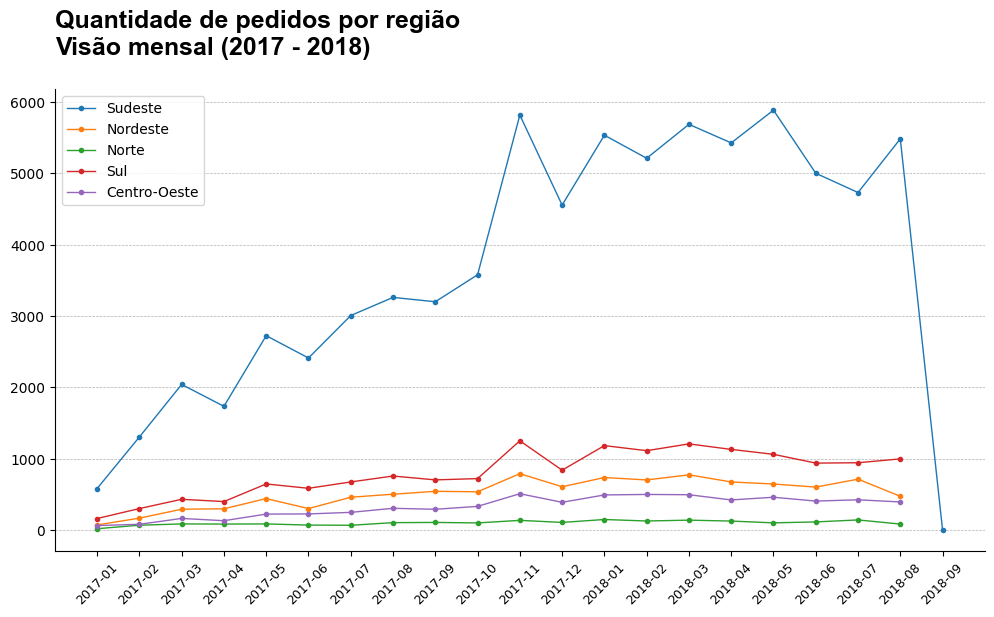

In [64]:
plt.figure(figsize=(12,6))
df_region_month[df_region_month.region == 'Sudeste'].qtd_pedidos.plot(label = 'Sudeste', marker = '.', lw = 1)
df_region_month[df_region_month.region == 'Nordeste'].qtd_pedidos.plot(label = 'Nordeste', marker = '.', lw = 1)
df_region_month[df_region_month.region == 'Norte'].qtd_pedidos.plot(label = 'Norte', marker = '.', lw = 1)
df_region_month[df_region_month.region == 'Sul'].qtd_pedidos.plot(label = 'Sul', marker = '.', lw = 1)
df_region_month[df_region_month.region == 'Centro-Oeste'].qtd_pedidos.plot(label = 'Centro-Oeste', marker = '.', lw = 1)
plt.title('Quantidade de pedidos por região \nVisão mensal (2017 - 2018)\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
plt.xlabel('')
plt.legend()
plt.gca().set_xticks(range(len(df_region_month.index.unique())))
plt.gca().set_xticklabels(df_region_month.index.unique(), rotation=45)
plt.gca().xaxis.set_tick_params(labelsize = 9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True, linestyle = '--', axis='y', linewidth = .5)
plt.show()

Todas as regiões apresentaram crescimento de 2017 para 2018, com exceção da região Norte que permaneceu com um volume estável de pedidos.  
Além disso, a região Sudeste se destaca apresentando maior crescimento entre o mesmo período.

In [70]:
df_region = df_status.groupBy('region').agg(
    f.count('order_id').alias('qtd_pedidos'),
    f.sum('order_value').alias('valor_total'),
    f.avg('order_value').alias('tkm'),
    f.avg('freight_value').alias('valor_medio_frete'),
    f.sum('canceled').alias('qtd_cancelados')
).orderBy('qtd_pedidos', ascending = False).toPandas().set_index('region')

df_region.head()

,qtd_pedidos,valor_total,tkm,valor_medio_frete,qtd_cancelados
region,,,,,
Sudeste,77402,1.007250e+07,130.132340,20.500021,426
Sul,16149,2.229846e+06,138.079540,25.582157,59
Nordeste,10407,1.718241e+06,165.104334,37.458679,32
Centro-Oeste,6613,1.011032e+06,152.885584,27.739472,21
Norte,2064,3.643962e+05,176.548527,42.192616,4


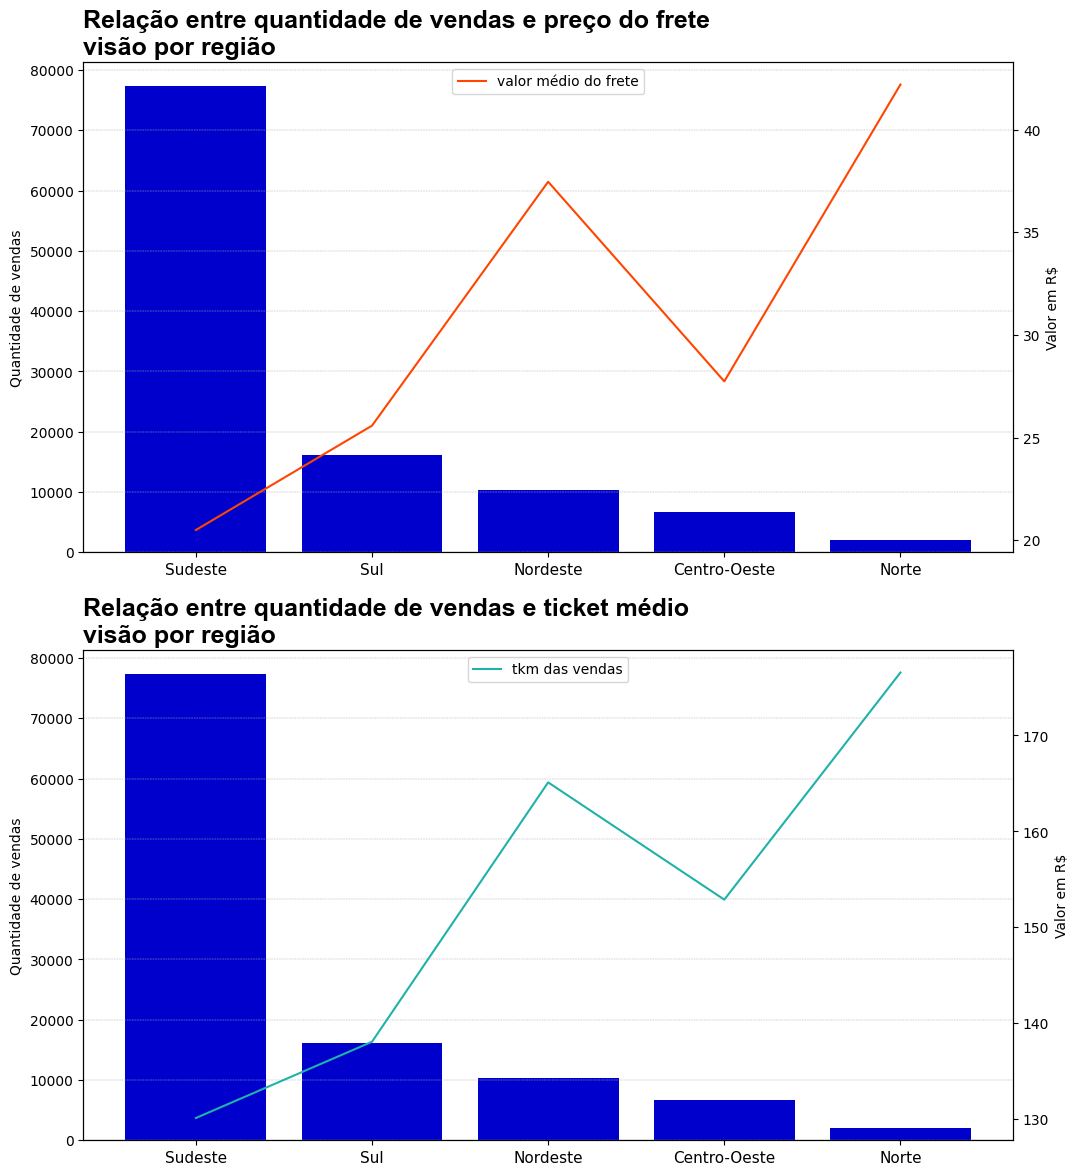

In [71]:
fig, ax = plt.subplots(2,1,figsize = (12,14))
ax2 = [ax[0].twinx(), ax[1].twinx()]

# gráfico 1
ax[0].bar(x = df_region.index, height = df_region.qtd_pedidos, color = 'mediumblue')
ax[0].set_title('Relação entre quantidade de vendas e preço do frete \nvisão por região', fontfamily = 'arial', fontweight = 'bold', fontsize = 18, loc = 'left')
ax[0].xaxis.set_tick_params(labelsize = '11')
ax[0].set_ylabel('Quantidade de vendas')
ax[0].grid(True, linestyle = '--', axis = 'y', linewidth = .35)
ax2[0].plot(df_region.valor_medio_frete, color = 'orangered', label = 'valor médio do frete', lw = 1.5)
ax2[0].set_ylabel('Valor em R$')
ax2[0].legend(loc='upper center')

# gráfico 2
ax[1].bar(x = df_region.index, height = df_region.qtd_pedidos, color = 'mediumblue')
ax[1].set_title('Relação entre quantidade de vendas e ticket médio \nvisão por região', fontfamily = 'arial', fontweight = 'bold', fontsize = 18, loc = 'left')
ax[1].xaxis.set_tick_params(labelsize = '11')
ax[1].set_ylabel('Quantidade de vendas')
ax[1].grid(True, linestyle = '--', axis = 'y', linewidth = .35)
ax2[1].plot(df_region.tkm, color = 'lightseagreen', label = 'tkm das vendas', lw = 1.5)
ax2[1].set_ylabel('Valor em R$')
ax2[1].legend(loc='upper center')

Com ambos os gráficos, é possível perceber os indicadores de valores do frete e ticket médio dos pedidos fora das regiões próximas ao Sudeste são bem mais altos, isso pode indicar que:

  - Apesar de uma volumetria menor de pedidos nas regiões Nordeste, Centro-Oeste e Norte. Os pedidos apresentam, em média, um valor de venda maior que as regiões com maiores volumetrias. 
  - Os valores de fretes mais altos para as regiões Nordeste, Centro-Oeste e Norte podem justificar a menor volumetria nessas regiões.

#### Vendas por estado

In [74]:
df_state = df_status.groupBy('state').agg(
    f.count('order_id').alias('qtd_pedidos'),
    f.sum('order_value').alias('valor_total'),
    f.avg('order_value').alias('tkm'),
    f.avg('freight_value').alias('valor_medio_frete'),
    f.sum('canceled').alias('qtd_cancelados')
).orderBy('qtd_pedidos', ascending = False).toPandas().set_index('state')

df_state.head()

,qtd_pedidos,valor_total,tkm,valor_medio_frete,qtd_cancelados
state,,,,,
SP,47444,5.899905e+06,124.355142,18.026840,293
RJ,14576,2.089311e+06,143.339138,24.641677,69
MG,13126,1.774152e+06,135.163183,24.079039,56
RS,6233,8.542738e+05,137.056608,25.814091,23
PR,5740,7.876328e+05,137.218260,25.208310,21


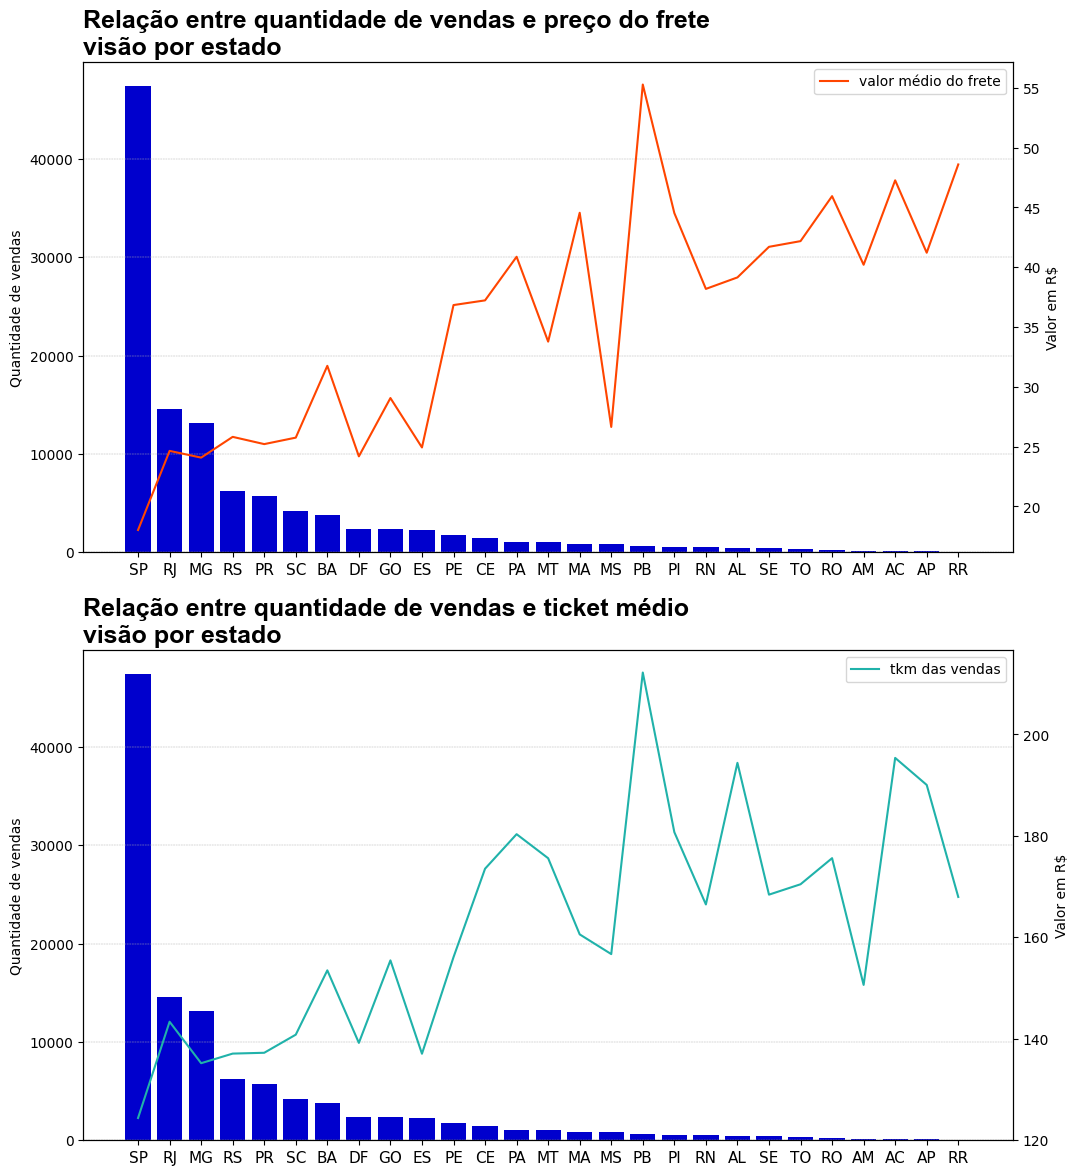

In [75]:
fig, ax = plt.subplots(2,1,figsize = (12,14))
ax2 = [ax[0].twinx(), ax[1].twinx()]

# gráfico 1
ax[0].bar(x = df_state.index, height = df_state.qtd_pedidos, color = 'mediumblue')
ax[0].set_title('Relação entre quantidade de vendas e preço do frete \nvisão por estado', fontfamily = 'arial', fontweight = 'bold', fontsize = 18, loc = 'left')
ax[0].xaxis.set_tick_params(labelsize = '11')
ax[0].set_ylabel('Quantidade de vendas')
ax[0].grid(True, linestyle = '--', axis = 'y', linewidth = .35)
ax2[0].plot(df_state.valor_medio_frete, color = 'orangered', label = 'valor médio do frete')
ax2[0].set_ylabel('Valor em R$')
ax2[0].legend()

# gráfico 2
ax[1].bar(x = df_state.index, height = df_state.qtd_pedidos, color = 'mediumblue')
ax[1].set_title('Relação entre quantidade de vendas e ticket médio \nvisão por estado', fontfamily = 'arial', fontweight = 'bold', fontsize = 18, loc = 'left')
ax[1].xaxis.set_tick_params(labelsize = '11')
ax[1].set_ylabel('Quantidade de vendas')
ax[1].grid(True, linestyle = '--', axis = 'y', linewidth = .35)
ax2[1].plot(df_state.tkm, color = 'lightseagreen', label = 'tkm das vendas')
ax2[1].set_ylabel('Valor em R$')
ax2[1].legend()

Por fim, a visão por estado é bem similar a visão por região, isto é, estados de regiões diferentes de Sul e Sudeste apresentam maior valor de frete e ticket médio apesar da menor volumetria de pedidos.

#### Tempo (dias da semana, horários, compras entre os anos)

In [90]:
def momento_dia(hour):
    if hour <= 12:
        return 'morning'
    elif hour <= 18:
        return 'afternoon'
    else: 
        return 'evening' 

dias = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df_time = df.withColumn('day_week', f.date_format('order_purchase_timestamp', 'EEEE')) \
       .withColumn('hour', f.hour('order_purchase_timestamp')) \
       .withColumn('day_moment', f.udf(momento_dia, StringType())(f.col('hour'))) \
       .withColumn('month', f.month('order_purchase_timestamp')) \
       .withColumn('year', f.year('order_purchase_timestamp'))

df_time.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+---------+----+----------+-----+----+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date| day_week|hour|day_moment|month|year|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+---------+----+----------+-----+----+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:00|2017-10-02 11:07:00|         2017-10-04 19:55:00|          2017-10-10 21:25:00|          2017-10-18 00:00:00|   Monday|  10|   morning|   10|2017|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:00|2018-07

In [91]:
df_year = df_time.groupBy('month').agg(
    f.sum(f.when(df_time.year == 2017, 1).otherwise(0)).alias('qtd_pedidos_2017'),
    f.sum(f.when(df_time.year == 2018, 1).otherwise(0)).alias('qtd_pedidos_2018')
).orderBy('month').toPandas().set_index('month')

df_year.head()

,qtd_pedidos_2017,qtd_pedidos_2018
month,,
1,800,7269
2,1780,6728
3,2682,7211
4,2404,6939
5,3700,6873


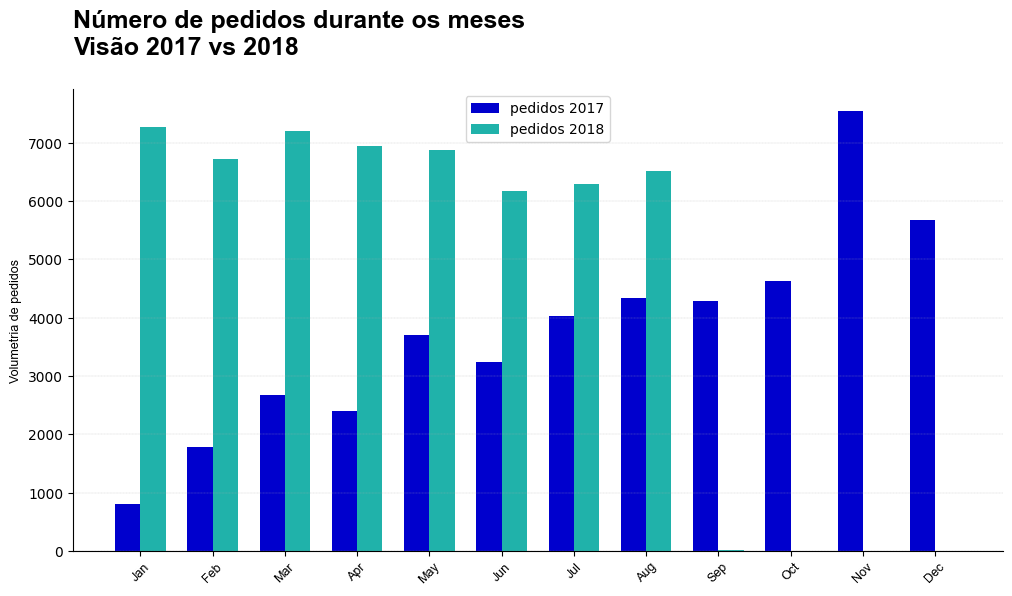

In [92]:
plt.figure(figsize = (12, 6))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().xaxis.set_ticklabels([0,'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize = 9, rotation = 45, fontfamily = 'arial')
plt.title('Número de pedidos durante os meses \nVisão 2017 vs 2018\n', fontfamily = 'arial', fontweight = 'bold', fontsize = 18, loc = 'left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_ylabel('Volumetria de pedidos', fontfamily = 'arial', fontsize = 9)
plt.grid(True, linestyle = '--', axis = 'y', linewidth = .2)
plt.bar(x = df_year.index-.35/2, height = df_year.qtd_pedidos_2017, width = .35, color = 'mediumblue', label = 'pedidos 2017')
plt.bar(x = df_year.index+.35/2, height = df_year.qtd_pedidos_2018, width = .35, color = 'lightseagreen', label = 'pedidos 2018')
plt.legend()
plt.show()

Vemos um crescimento na quantidade de pedidos durante todo o ano de 2017, já em 2018 a quantidade de pedidos se manteve mais estável variando em torno de aproximadamente 6.500 pedidos.

In [94]:
df_daymoment = df_time.groupBy('day_moment').agg(
    f.sum(f.when(df_time.year == 2017, 1).otherwise(0)).alias('qtd_pedidos_2017'),
    f.sum(f.when(df_time.year == 2018, 1).otherwise(0)).alias('qtd_pedidos_2018')
).orderBy('day_moment').toPandas().set_index('day_moment')

df_daymoment.head()

,qtd_pedidos_2017,qtd_pedidos_2018
day_moment,,
afternoon,17149,20869
evening,13128,15113
morning,14824,18029


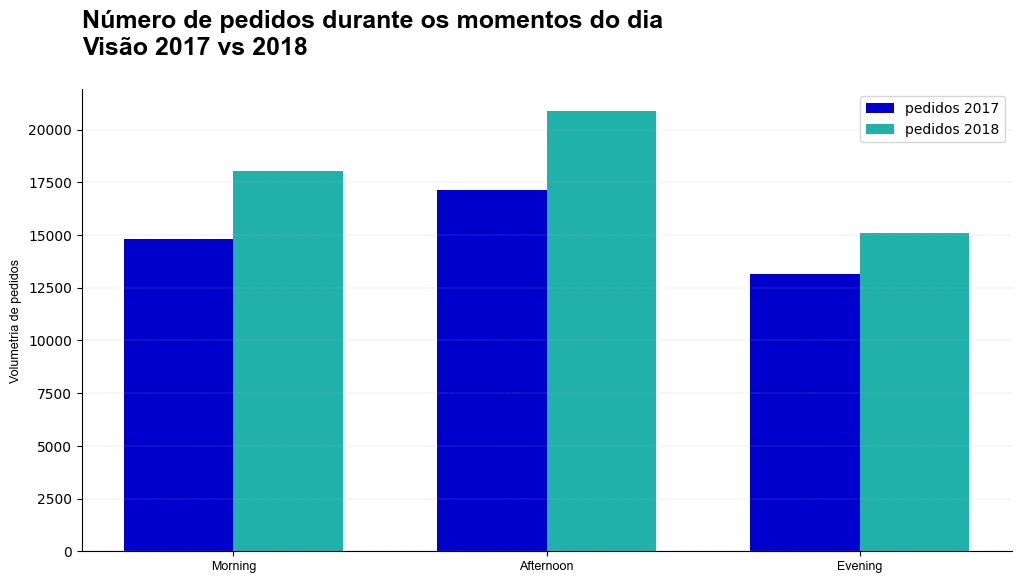

In [97]:
plt.figure(figsize = (12, 6))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().xaxis.set_ticklabels([0,'Morning', 'Afternoon', 'Evening'], fontsize = 9, fontfamily = 'arial')
plt.gca().set_ylabel('Volumetria de pedidos', fontfamily = 'arial', fontsize = 9)
plt.title('Número de pedidos durante os momentos do dia \nVisão 2017 vs 2018\n', fontfamily = 'arial', fontweight = 'bold', fontsize = 18, loc = 'left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True, linestyle = '--', axis = 'y', linewidth = .2)
plt.bar(x = df_daymoment.index.map({'morning': 0, 'afternoon': 1, 'evening': 2})-.35/2, height = df_daymoment.qtd_pedidos_2017, width = .35, color = 'mediumblue', label = 'pedidos 2017')
plt.bar(x = df_daymoment.index.map({'morning': 0, 'afternoon': 1, 'evening': 2})+.35/2, height = df_daymoment.qtd_pedidos_2018, width = .35, color = 'lightseagreen', label = 'pedidos 2018')
plt.legend()
plt.show()

Os dados mostram que a maior parte dos pedidos são feitos durante a tarde, seguidos pela manhã e por último durante a noite. Esse padrão se manteve durante os dois anos avaliados.

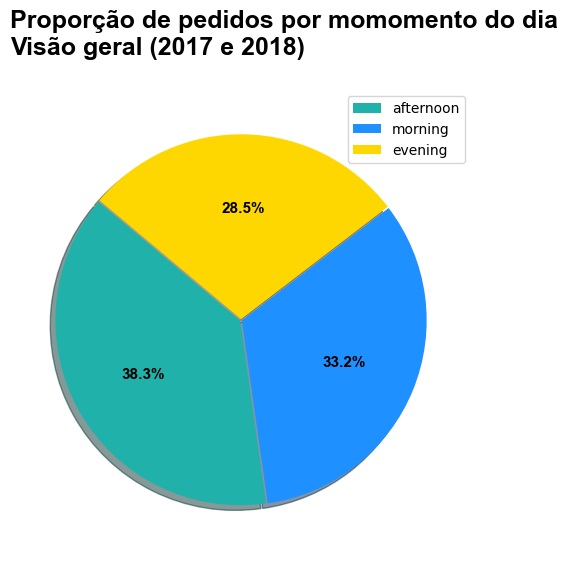

In [100]:
df_daymoment = df_time.groupBy('day_moment').agg(f.count('order_id').alias('qtd_pedidos')).toPandas().set_index('day_moment')

plt.figure(figsize = (12,6))
plt.title('Proporção de pedidos por momomento do dia \nVisão geral (2017 e 2018)\n', fontfamily = 'arial', fontweight = 'bold', fontsize = 18, loc ='left')
patches, texts, autotexts = plt.pie(
    df_daymoment.qtd_pedidos, 
    labels = df_daymoment.index,
    autopct = '%1.1f%%', 
    pctdistance = 0.6, 
    startangle = 140, 
    shadow = True, 
    explode = [0.005, 0.005, 0.005],
    colors = ['lightseagreen', 'dodgerblue', 'gold']
)

for autotext in autotexts:
    autotext.set_color('black')  
    autotext.set_fontweight('bold') 
    autotext.set_fontfamily('arial')
    autotext.set_fontsize(11)

for text in texts:
    text.set_visible(False)

plt.legend()

plt.show()

Essa visão mostra como a proporção de pedidos durante a tarde representa maior parcela dos pedidos considerando os 2 anos avaliados.